### Visualizing the distribution of the observations

### Load the required libraries

In [56]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12886
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMAX|USC00058212|     4|[00 CF 00 D3 80 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TMIN|USC00058212|    13|[A0 DB 00 7E 28 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TOBS|USC00058212|     2|[40 D6 28 D8 E0 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     8|[20 D0 E0 D5 00 7...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     3|[00 46 00 D3 00 7...|2000.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [137]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNOW','USC00058212')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TMAX')#,'USC00058212')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX'
2516 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMAX|USC00058212|     4|[00 CF 00 D3 80 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     8|[20 D0 E0 D5 00 7...|1999.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2516, 365)

In [80]:
df_tmin_tmax = pd.DataFrame(np.nanmean(T,axis=0,dtype=float),columns =['TMAX'])

In [138]:
df_tmin_tmax['TMAX'] = (np.nanmean(T,axis=0,dtype=float)*(9/5))+32

In [139]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNOW','USC00058212')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TMIN')#,'USC00058212')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN'
2521 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMIN|USC00058212|    13|[A0 DB 00 7E 28 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMIN|USS0005K26S|    12|[A0 D7 E0 D8 38 D...|1999.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2521, 365)

In [140]:
df_tmin_tmax['TMIN'] = (np.nanmean(T,axis=0,dtype=float)*(9/5))+32

In [93]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNOW','USC00058212')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('PRCP')#,'USC00058212')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP'
2849 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2680.1| 39.4905|-105.5239|       PRCP|US1COPK0069|    32|[00 00 00 00 00 0...|2006.0|SSSBBBBB|
|   2680.1| 39.4905|-105.5239|       PRCP|US1COPK0069|    14|[00 00 00 00 00 0...|2007.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2849, 365)

In [114]:
df_tmin_tmax['PRCP'] = np.nanmean(T,axis=0,dtype=float)

In [135]:
np.nanmean(T,dtype=float)*365/12

38.139562129001803

### Script for plotting yearly plots

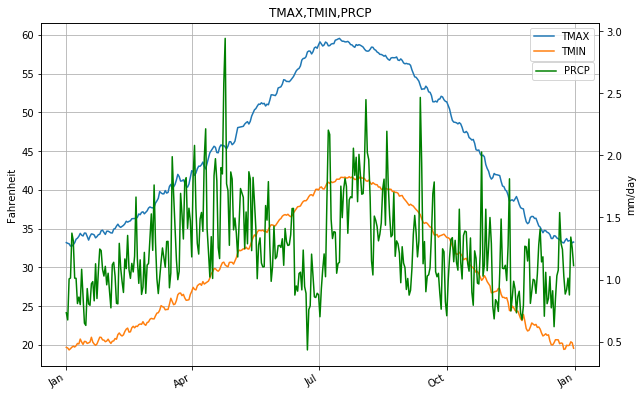

In [141]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
#print T[:2,:].transpose()
YP.plot(df_tmin_tmax.as_matrix()[:,:2],fig,ax,title='TMAX,TMIN,PRCP',labels=['TMAX','TMIN'])
#n, bins, patches = ax.hist(df_tmin_tmax['PRCP'])
ax1 = ax.twinx()
ax1.plot(YP.dates,df_tmin_tmax['PRCP'],color='green')
ax1.set_ylabel('mm/day')
ax.set_ylabel('Fahrenheit')
ax1.legend(bbox_to_anchor=(1.0, .9), bbox_transform=ax.transAxes)
#ax.legend()
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [24]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

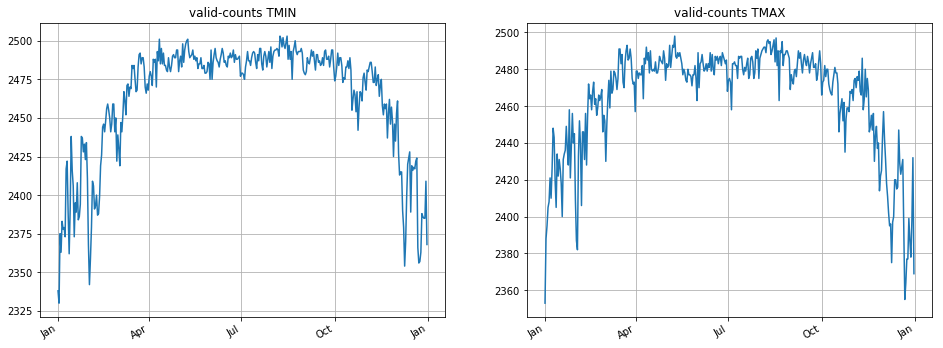

In [25]:
plot_pair(['TMIN','TMAX'],plot_valid)

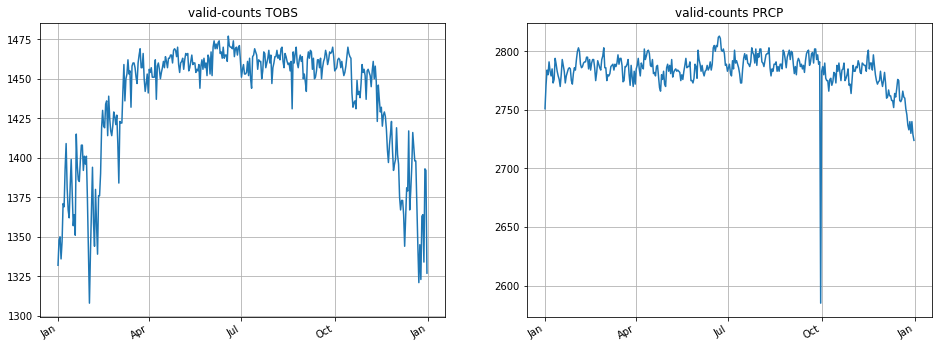

In [26]:
plot_pair(['TOBS','PRCP'],plot_valid)

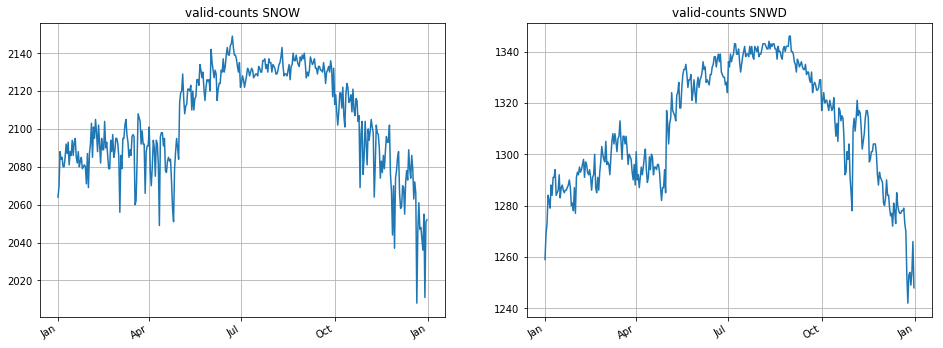

In [27]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [64]:
T

array([[ -2.80078125,  -5.6015625 ,  -4.3984375 , ...,  -2.80078125,
         -1.70019531,   1.09960938],
       [ -3.30078125,  -9.3984375 ,          nan, ...,          nan,
          3.30078125,   2.80078125],
       [  0.60009766,  -5.6015625 ,          nan, ...,  -0.60009766,
         -3.30078125,  -3.90039062],
       ..., 
       [ -0.60009766,   6.69921875,   6.69921875, ...,  10.6015625 ,
         11.1015625 ,   9.3984375 ],
       [  8.296875  ,  11.1015625 ,   1.70019531, ...,   2.80078125,
          0.        ,   1.70019531],
       [  7.80078125,   7.19921875,   0.60009766, ...,   7.19921875,
         -3.90039062,          nan]], dtype=float16)

In [59]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

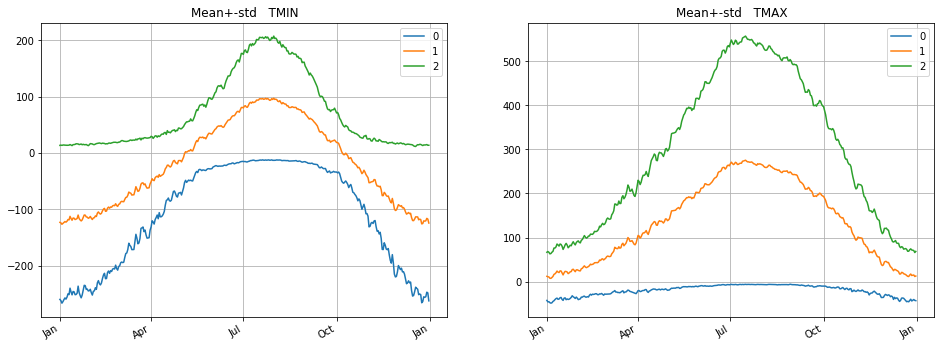

In [60]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

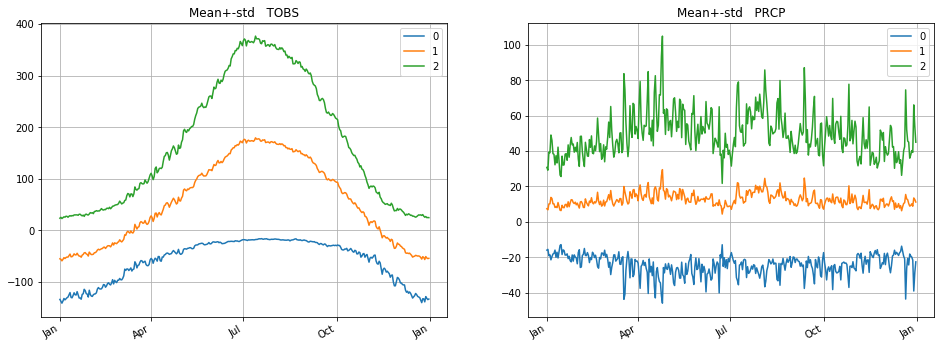

In [30]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

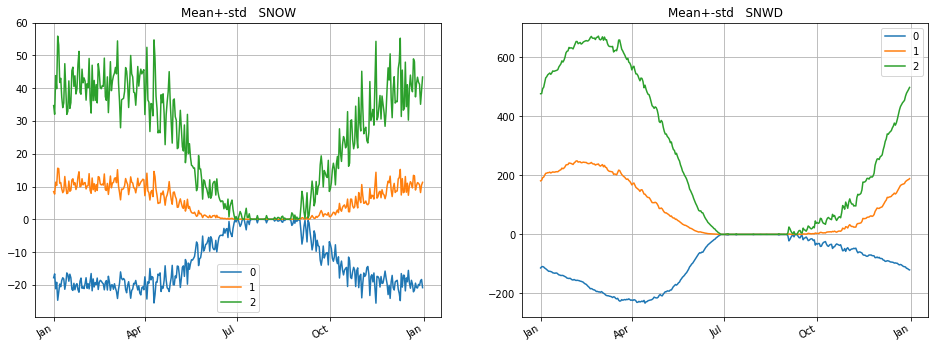

In [31]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [146]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:2],fig,axis,title='Top Eigenvectors '+m)

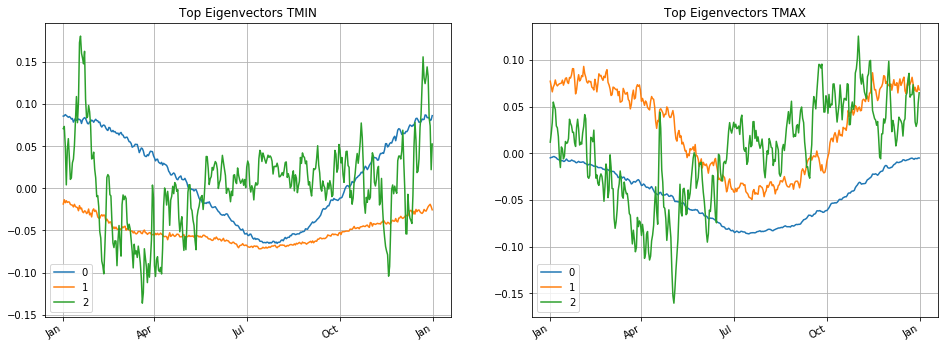

In [33]:
plot_pair(['TMIN','TMAX'],plot_eigen)

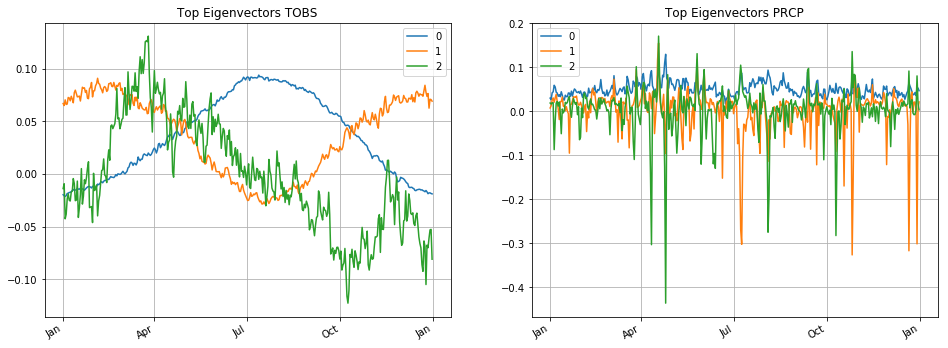

In [34]:
plot_pair(['TOBS','PRCP'],plot_eigen)

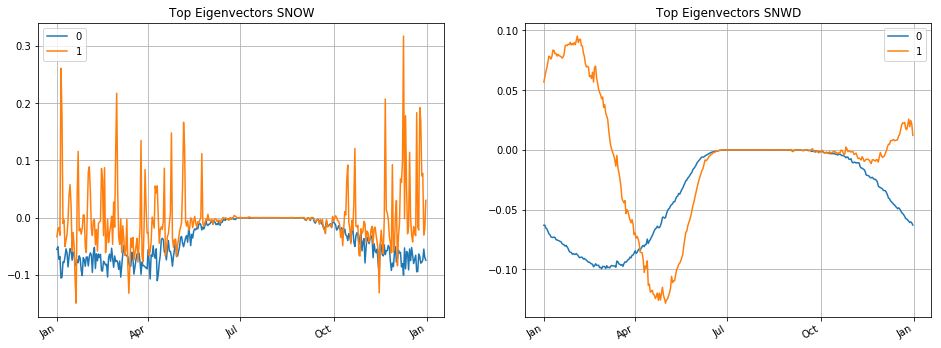

In [147]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [36]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

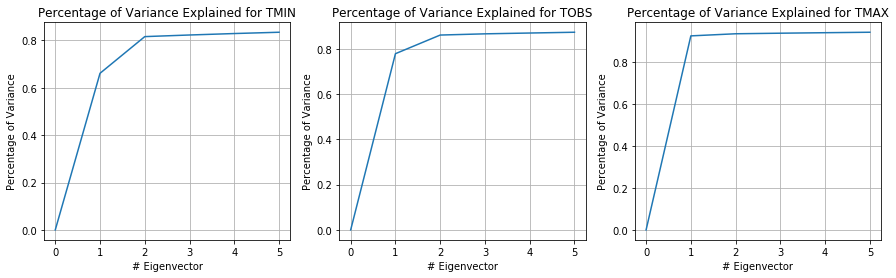

In [142]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

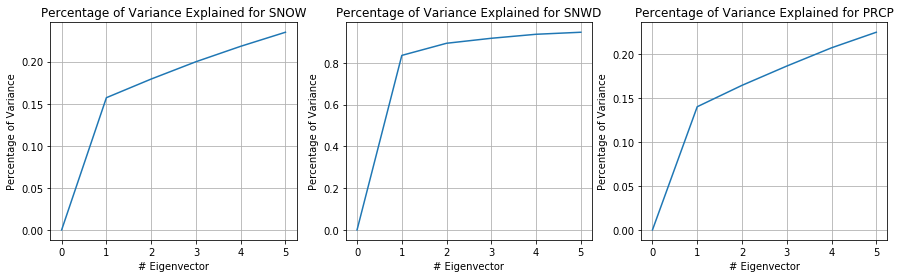

In [143]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [39]:
sc.stop()